=== Matriz de Hückel H (eV) ===
      O(1)  C(2)  N(3)  C(4)  C(5)
O(1)  -2.5  -2.0  0.00   0.0  -2.0
C(2)  -2.0   0.0 -2.50   0.0   0.0
N(3)   0.0  -2.5 -1.25  -2.0   0.0
C(4)   0.0   0.0 -2.00   0.0  -2.5
C(5)  -2.0   0.0  0.00  -2.5   0.0

=== k usados por ligação ===
O(1)–C(2): k = 0.800
C(2)–N(3): k = 1.000
N(3)–C(4): k = 0.800
C(4)–C(5): k = 1.000
C(5)–O(1): k = 0.800

=== Energias (eV) – níveis de Hückel ===
MO1: -5.285633
MO2: -2.690340
MO3: -1.798836 (HOMO)
MO4: 2.657663 (LUMO)
MO5: 3.367146

=== Coeficientes dos Orbitais Moleculares (colunas = MOs) ===
           MO1       MO2       MO3       MO4       MO5
O(1)  0.588381  0.646192 -0.201983  0.430476  0.100682
C(2)  0.431102 -0.130551 -0.505073 -0.690180  0.256242
N(3)  0.440753 -0.657445 -0.201831  0.389326 -0.425667
C(4)  0.350482 -0.310283  0.575955  0.102047  0.662381
C(5)  0.388405  0.192049  0.575885 -0.419944 -0.551600

=== Populações eletrônicas π por átomo ===
O(1): 1.609
C(2): 0.916
N(3): 1.334
C(4): 1.102
C(5): 1.0

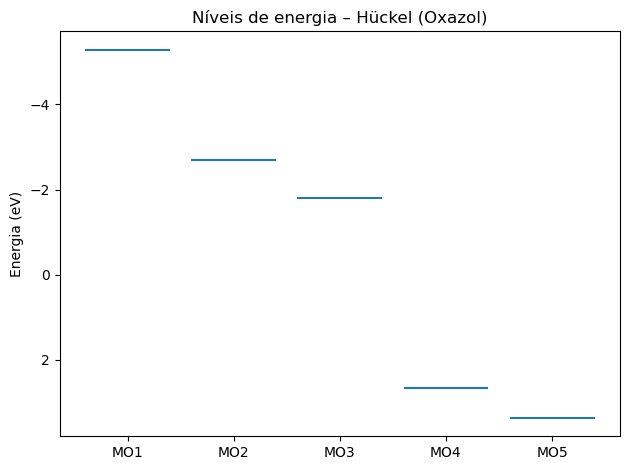

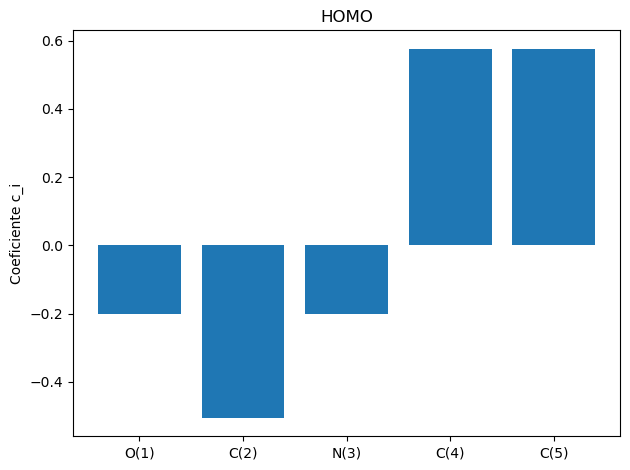

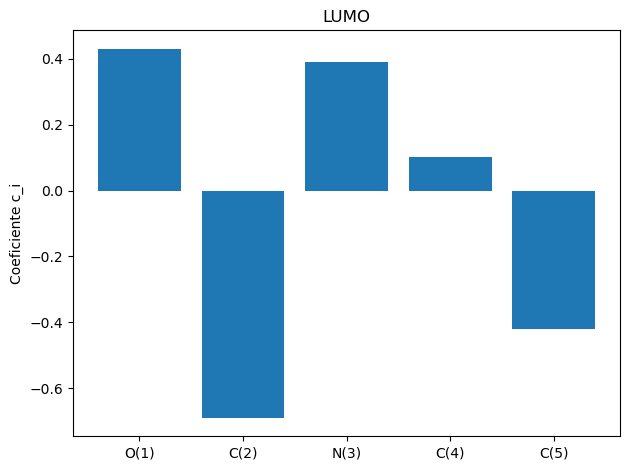

In [4]:
# Hückel para o oxazol (1,3-oxazol) com parâmetros da sua aula
# Correção solicitada: C(2)=N(3) como dupla  -> k_CN = 1.0

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# 1) Parâmetros (tabela da aula)
# -------------------------
beta0  = -2.5  # eV  (β_CC)
alphaC = 0.0   # referência α_C

# h_x (deslocamento de α_x = α_C + h_x β0)
h = {
    "C": 0.0,
    "N_piridina": 0.5,  # N sp2 tipo piridina (1 elétron π)
    "O_furano":   1.0,  # O em anel tipo furano
}

# k_{Cx} típicos da tabela (valores "aromáticos" padrão)
k_aromatic = {
    ("C","C"): 1.0,
    ("C","N_piridina"): 0.8,
    ("C","O_furano"):   0.8,
}

# -------------------------
# 2) Molécula e numeração
# -------------------------
# 1=O, 2=C2, 3=N3, 4=C4, 5=C5
atoms  = ["O_furano", "C", "N_piridina", "C", "C"]
labels = ["O(1)", "C(2)", "N(3)", "C(4)", "C(5)"]

# Ligações do anel
# (i, j, tipo) — vou usar 'aromatic' para padrão da tabela e
# sobrescrever a C(2)=N(3) como 'double' (k=1.0) conforme sua correção.
bonds = [
    (0, 1, "aromatic"),  # O(1)-C(2)
    (1, 2, "double"),    # C(2)=N(3)  <<-- k_CN = 1.0 (dupla)
    (2, 3, "aromatic"),  # N(3)-C(4)
    (3, 4, "aromatic"),  # C(4)-C(5)
    (4, 0, "aromatic"),  # C(5)-O(1)
]

# -------------------------
# 3) Monta a matriz de Hückel (em eV)
# -------------------------
n = len(atoms)
H = np.zeros((n, n), float)

# Diagonais: α_x
for i, ax in enumerate(atoms):
    H[i, i] = alphaC + h[ax] * beta0

# Funções auxiliares para k_ij por tipo de ligação
def k_default(a_i, a_j):
    # valor aromático padrão da tabela (simétrico)
    if (a_i, a_j) in k_aromatic:   return k_aromatic[(a_i, a_j)]
    if (a_j, a_i) in k_aromatic:   return k_aromatic[(a_j, a_i)]
    return 0.0

def k_for_bond(i, j, bond_type):
    ai, aj = atoms[i], atoms[j]
    if bond_type == "double":
        # regras: usa k=1.0 para dupla envolvendo N_piridina–C,
        # e 1.1 para C=C caso você queira testar depois.
        if {"N_piridina","C"} == {ai, aj}:
            return 1.0
        if ai == "C" and aj == "C":
            return 1.1  # se algum dia marcar C=C
        # fallback: se não reconhecido, usa 1.0
        return 1.0
    elif bond_type == "single":
        # se quiser marcar simples N–C como 0.7, poderia usar aqui.
        if {"N_piridina","C"} == {ai, aj}:
            return 0.7
        if ai == "C" and aj == "C":
            return 0.9
        if {"O_furano","C"} == {ai, aj}:
            return 0.8  # (aula costuma usar 0.8 para O–C no anel)
        return k_default(ai, aj)
    else:  # "aromatic" ou padrão
        return k_default(ai, aj)

# Preenche fora da diagonal: β_ij = k_ij * β0
k_used = {}  # para relatar quais k foram usados por ligação
for i, j, btype in bonds:
    kij = k_for_bond(i, j, btype)
    H[i, j] = H[j, i] = kij * beta0
    k_used[(i, j)] = kij

# -------------------------
# 4) Diagonalização (biblioteca)
# -------------------------
# eigh: matriz simétrica/hermitiana -> autovalores reais em ordem crescente
evals, evecs = np.linalg.eigh(H)  # energias e coeficientes MO

# -------------------------
# 5) Eletrônica π
# -------------------------
nelec = 6
n_occ = nelec // 2  # 3 MOs ocupados

# Populações por átomo: N_i = 2 * sum_{a=1..n_occ} c_{ia}^2
occ = evecs[:, :n_occ]
populations = 2.0 * np.sum(occ**2, axis=1)

# Ordens de ligação π: P_ij = 2 * sum_{a=1..n_occ} c_{ia} c_{ja}
P = np.zeros((n, n))
for a in range(n_occ):
    c = evecs[:, a]
    P += 2.0 * np.outer(c, c)

# -------------------------
# 6) Saídas tabulares
# -------------------------
print("=== Matriz de Hückel H (eV) ===")
print(pd.DataFrame(H, index=labels, columns=labels))
print("\n=== k usados por ligação ===")
for (i,j), kij in k_used.items():
    print(f"{labels[i]}–{labels[j]}: k = {kij:.3f}")

print("\n=== Energias (eV) – níveis de Hückel ===")
for m, E in enumerate(evals, 1):
    tag = " (HOMO)" if m == n_occ else (" (LUMO)" if m == n_occ+1 else "")
    print(f"MO{m}: {E:.6f}{tag}")

print("\n=== Coeficientes dos Orbitais Moleculares (colunas = MOs) ===")
print(pd.DataFrame(evecs, index=labels, columns=[f"MO{m}" for m in range(1, n+1)]))

print("\n=== Populações eletrônicas π por átomo ===")
for lbl, Ni in zip(labels, populations):
    print(f"{lbl}: {Ni:.3f}")

print("\n=== Ordens de ligação π (pares ligados) ===")
for i, j, _ in bonds:
    print(f"{labels[i]}–{labels[j]}: {P[i,j]:.3f}")

# -------------------------
# 7) Gráficos (níveis e HOMO/LUMO)
# -------------------------
plt.figure()
x = np.arange(1, n+1)
plt.hlines(evals, x-0.4, x+0.4)
plt.xticks(x, [f"MO{j}" for j in range(1, n+1)])
plt.ylabel("Energia (eV)")
plt.title("Níveis de energia – Hückel (Oxazol)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

def plot_mo_bar(mo_index, title):
    plt.figure()
    plt.bar(labels, evecs[:, mo_index])
    plt.ylabel("Coeficiente c_i")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_mo_bar(n_occ-1, "HOMO")
plot_mo_bar(n_occ,   "LUMO")
